# Breast Cancer Data Challenge

Your task is to develop a model that predicts whether a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes about the cell.

* Classification or regression: Classification
* Supervised or unsupervised: Supervised

## Data Description
The dataset consists of 699 cells for which you have the following features:
1. Sample code number: id number
2. Clump Thickness: 1 - 10
3. Uniformity of Cell Size: 1 - 10
4. Uniformity of Cell Shape: 1 - 10
5. Marginal Adhesion: 1 - 10
6. Single Epithelial Cell Size: 1 - 10
7. Bare Nuclei: 1 - 10
8. Bland Chromatin: 1 - 10
9. Normal Nucleoli: 1 - 10
10. Mitoses: 1 - 10
11. Class: (2 for benign, 4 for malignant)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from collections import Counter
from imblearn.over_sampling import SMOTE 
from scipy.stats import randint as sp_randint
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [2]:
# Read in txt file as data frame
df = pd.read_csv('./breast-cancer-wisconsin.data.txt', header = None)

In [3]:
# Name the columns
cols = ['id', 'thickness', 'uniformity size', 'uniformity shape', 'marginal adhesion', 'epithelial cell size', 'bare nuclei', 'bland chromatin', 'normal nucleoli', 'mitoses', 'class'] 
df.columns = cols

In [4]:
# Print first five rows
df.head()

,id,thickness,uniformity size,uniformity shape,marginal adhesion,epithelial cell size,bare nuclei,bland chromatin,normal nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [5]:
# Define class, features, IDs
classes = df['class']                 # just classes
features = df.drop(['class','id'], 1) # just the features
feat_class = df.drop('id', 1)         # features and classes
ids = df['id']                        # just IDs

[[<matplotlib.text.Text at 0x119ba7c10>,

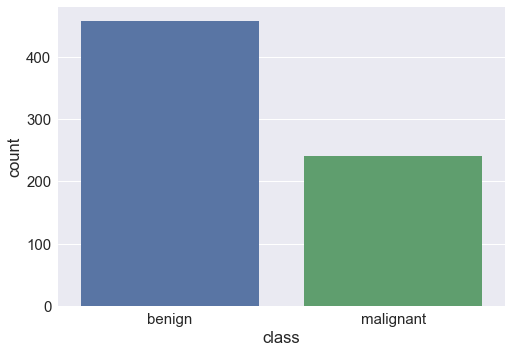

In [6]:
# Plot how many data points there are for each class
sns.set(font_scale=1.5)              # make the font bigger
fig = sns.countplot(classes)
fig.set(xticklabels=['benign', 'malignant'])

This is an unbalanced dataset where benign tumors occur ~2x more than malignant ones. I'll talk about how to address this later.

## Missing Values

I want to find the missing values and determine the best method for imputing or removing them. The most important questions are: How many missing values? Where are they in the data? What is the nature of the data where the values are missing?

In [7]:
# Are there any null values? NaN are represented by '?' in data
features = features.replace('?', np.nan)        # Replace ? with NaN
print features.isnull().sum().sum()             # How many NaN in data

# Show where the null values occur
df_null = features.isnull().unstack()
print df_null[df_null]

# Find indices of null values
null_ind = pd.isnull(features).any(1).nonzero()[0]

16
bare nuclei  23     True
             40     True
             139    True
             145    True
             158    True
             164    True
             235    True
             249    True
             275    True
             292    True
             294    True
             297    True
             315    True
             321    True
             411    True
             617    True
dtype: bool


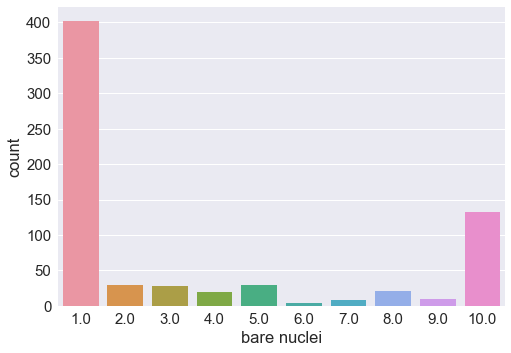

In [8]:
# See how many of each number are represented
# Need to use float because int produces error with NaN
fig = sns.countplot(features['bare nuclei'].astype(float))

There are only 16 missing values, all in the bare nuclei. After looking up how bare nuclei are used in cancer detection, I believe setting the value of bare nuclei to the mean, median, or mode isn't desired. With more time, I would model the bare nuclei to impute the missing values. But given the time constraint and how few missing values there are, I'm going to drop the missing values.

In [9]:
# Impute missing values with mode of column
X = features.dropna()
X = X.astype(int)      # Convert to integer, the bare nuclei column is string

In [10]:
# Drop null rows
classes = classes.drop(null_ind, axis=0)
feat_class = feat_class.drop(null_ind, axis=0)
ids = ids.drop(null_ind, axis=0)

# Make the targets array with benign = 2 --> 0, malignant = 4 --> 1
y = classes.replace(2, 0)
y = y.replace(4, 1)

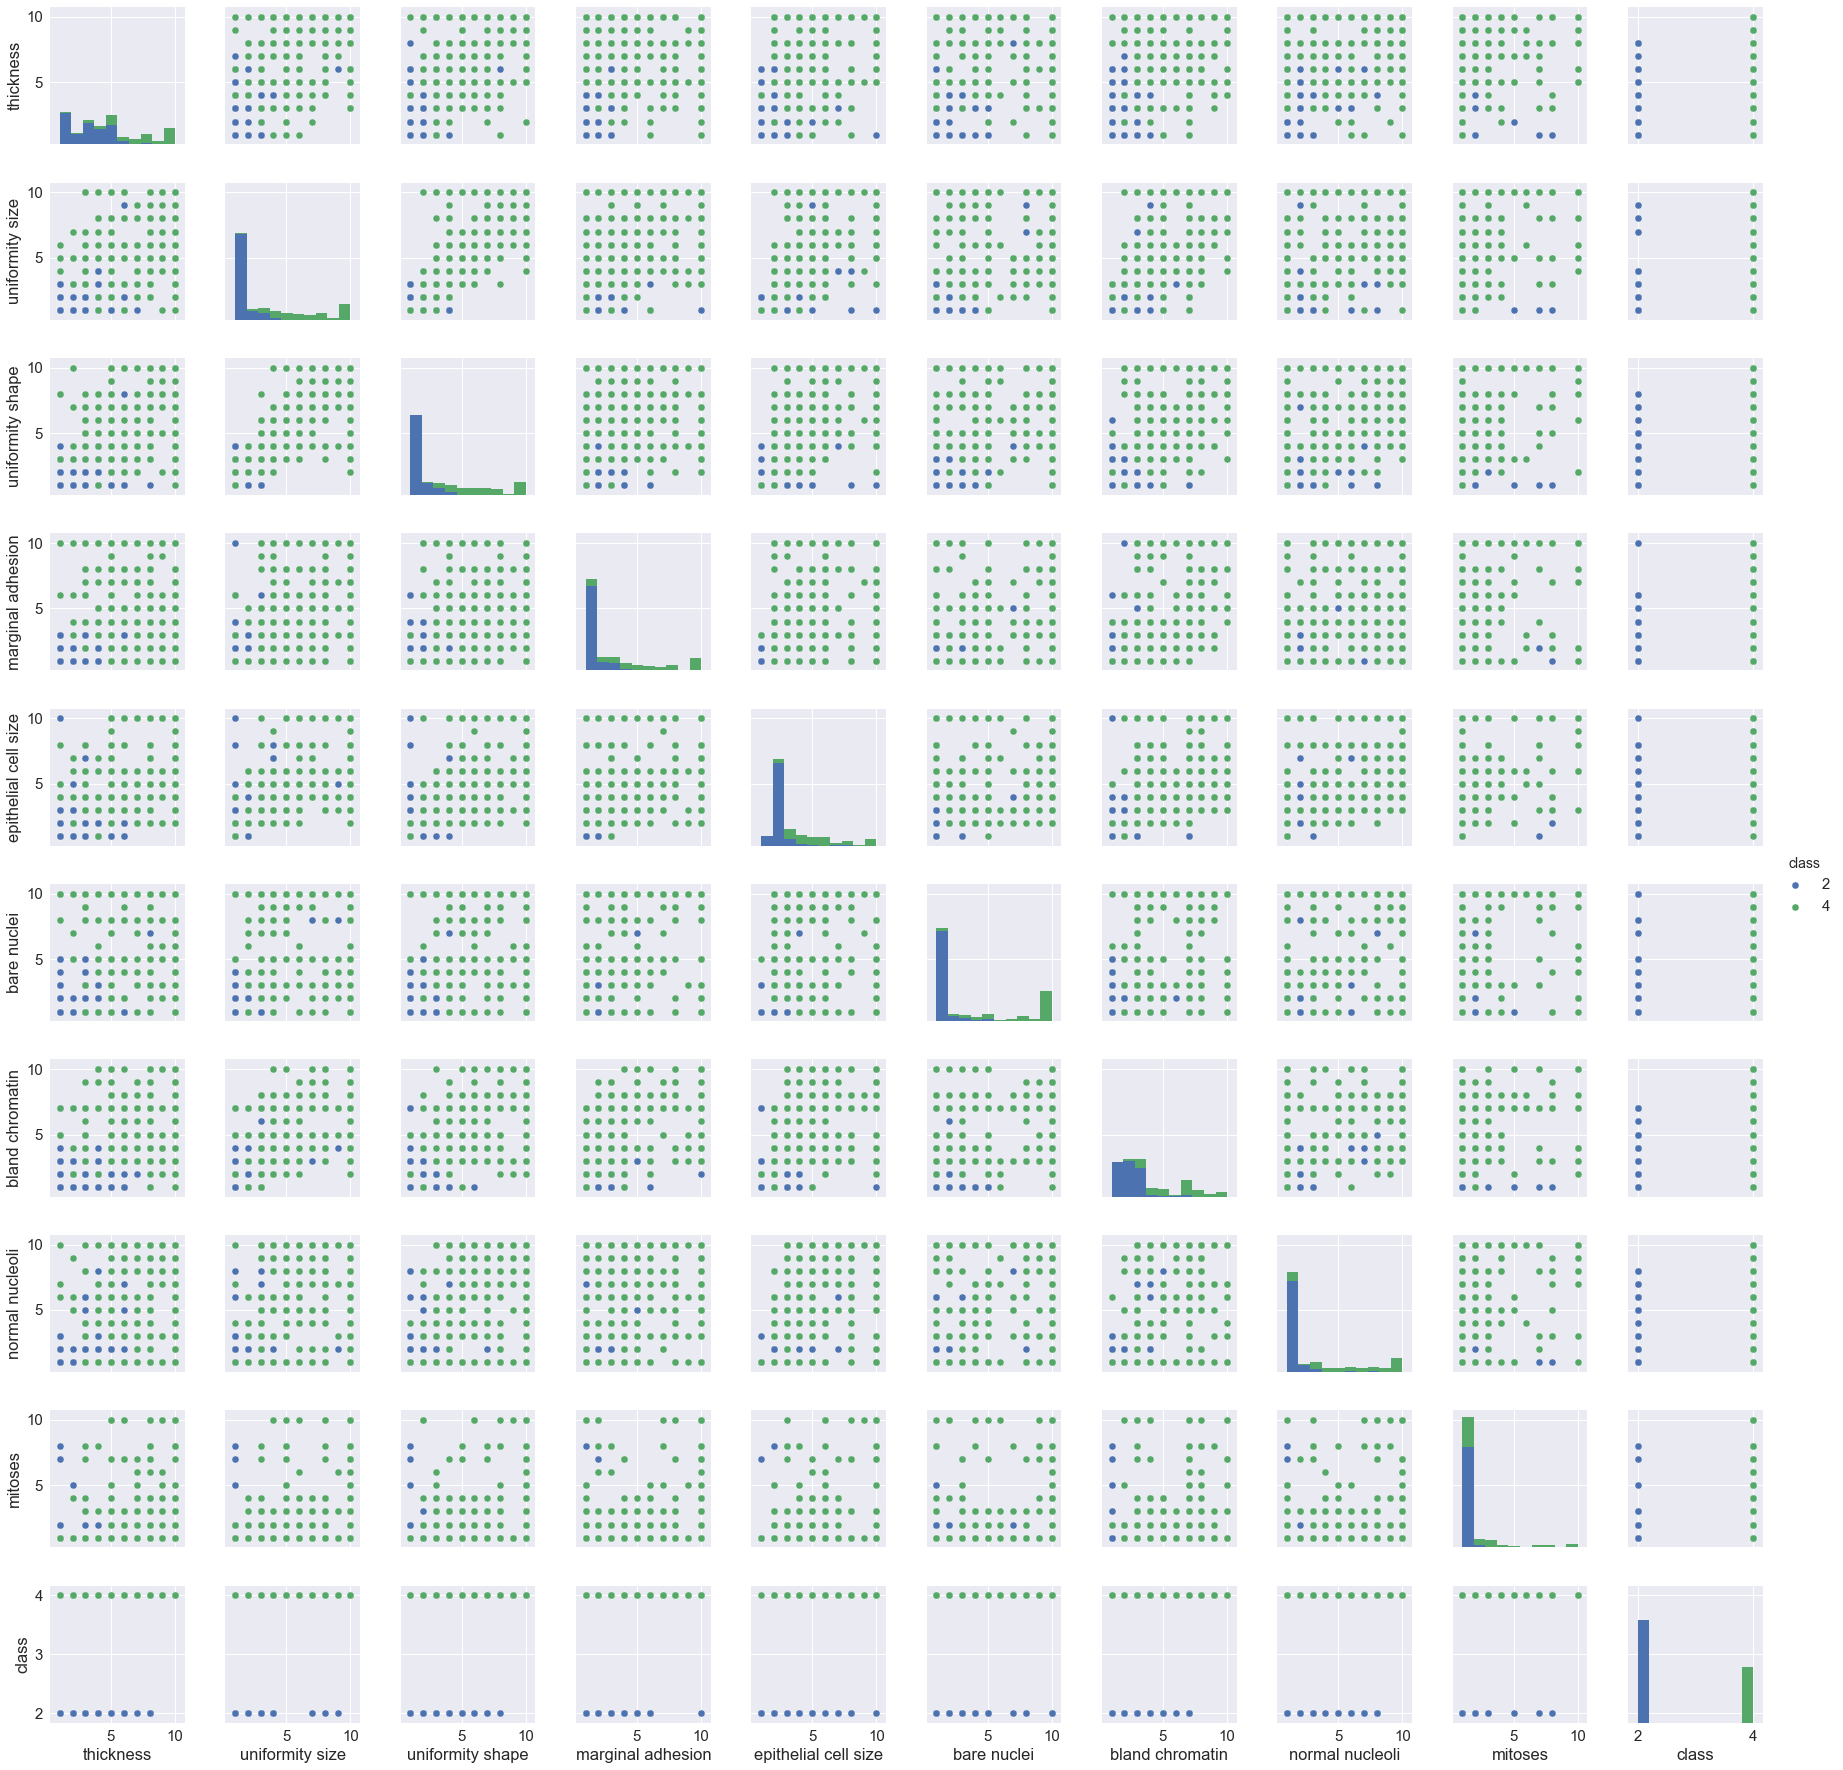

In [11]:
sns.pairplot(feat_class.astype(int), hue = 'class')

## Unbalanced data

There are twice as many benign points as malignant, so the data are unbalanced. Since we have a relatively small number of data points, we'll use SMOTE to balance the data.

In [12]:
print 'Original dataset shape {}'.format(Counter(y))
sm = SMOTE()
X_res, y_res = sm.fit_sample(X, y)
print 'Resampled dataset shape {}'.format(Counter(y_res))

Original dataset shape Counter({0: 444, 1: 239})
Resampled dataset shape Counter({0: 444, 1: 444})


## Running and interpreting the model

I'm choosing the Random Forest Classifier. Given the time constraint, I wanted a model that didn't need hyperparameter tuning, was relatively fast, and was intuitive.

I'm doing a train/test split since there isn't a separate testing set. For performance metrics I could have done k-fold cross-validation.

In [13]:
# Train/test split: want to test the model on testing data it has never seen
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2)

In [14]:
# Define the classifier, fit on training data
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [15]:
# Show feature importances
importances = rf.feature_importances_
print importances

[ 0.02292959  0.45521498  0.10667491  0.00721634  0.10753317  0.18887524
  0.02150938  0.08438121  0.00566519]


In [16]:
# Classification report
target_names = ['benign', 'malignant']
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

     benign       0.97      0.99      0.98        92
  malignant       0.99      0.97      0.98        86

avg / total       0.98      0.98      0.98       178



In [17]:
# Define confusion matrix plot - from sklearn example
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[91  1]
 [ 3 83]]


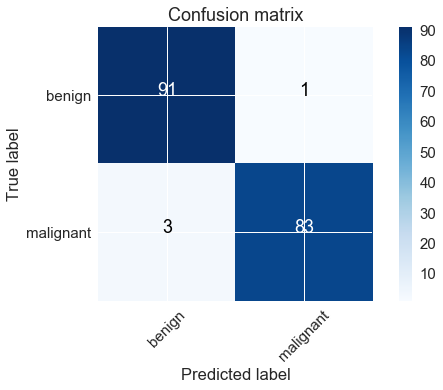

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')

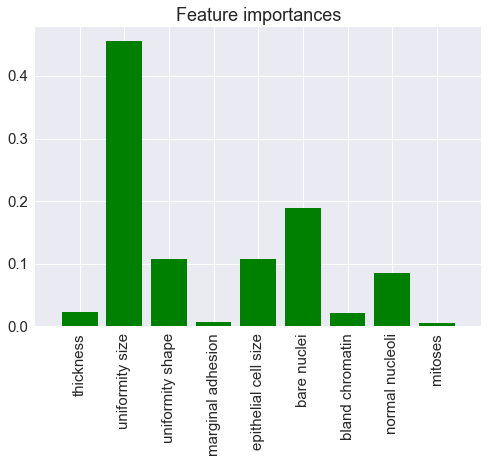

In [19]:
# Plot feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances,
       color="g", align="center")
plt.xticks(np.arange(X_test.shape[1]), ('thickness', 'uniformity size', 'uniformity shape', 'marginal adhesion', 
            'epithelial cell size', 'bare nuclei', 'bland chromatin', 'normal nucleoli', 
            'mitoses'), rotation=90)
plt.xlim([-1, X_test.shape[1]])
plt.show()